In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


In [2]:
!pip install pandas

In [3]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)


# CNN-Kim Model
I can't get it exactly the same now because I'm using custom-trained word vectors instead of pre-trained ones, but I can still try to build a similar architecture.

Since there are different variations of his model, I'll start with a model with the following architecture:
- Using custom-trained word vectors (dimension = 200)
- Keeping those word vectors static during the trainin process (maybe - TBD while implementing)
- Single-channel
- Filter windows height of 3, 4, 5 with 100 feature maps each
- MaxPooling to extract the features from each feature map
- Dropout rate of 0.5
- ReLu activation function 

In [4]:
# Import the libraries
import os
import numpy as np
from numpy import load
from scipy.sparse import load_npz
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt

In [5]:
# Check that a GPU is available
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Not sure why, but I need this to get TF to work
# from: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
# Enable mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

### Load in the data

In [8]:
# Define the load path
load_path = '../Datasets/AmazonCat-13K/processed/'

In [9]:
# Load the X_train
X_train_data = load('../Datasets/AmazonCat-13K/processed/' + 'X_train.npz')
X_train = X_train_data['arr_0']

In [10]:
# Load the X_test
X_test_data = load('../Datasets/AmazonCat-13K/processed/' + 'X_test.npz')
X_test = X_test_data['arr_0']

In [11]:
# Load y_train
y_train_sparse = load_npz(load_path + 'y_train_sparse.npz')

In [12]:
# Load y_test
y_test_sparse = load_npz(load_path + 'y_test_sparse.npz')

In [13]:
# Create placeholder matrices that will be 'injected' with the values later
y_train_placeholder = np.zeros((y_train_sparse.shape[0], y_train_sparse.shape[1]), dtype='int8')
y_test_placeholder = np.zeros((y_test_sparse.shape[0], y_test_sparse.shape[1]), dtype='int8')

In [14]:
# # Create y_train
# y_train = tf.convert_to_tensor(y_train_sparse.todense(out=y_train_placeholder), dtype=tf.int8)

In [15]:
# # Create y_test
# y_test = tf.convert_to_tensor(y_test_sparse.todense(out=y_test_placeholder), dtype=tf.int8)

In [16]:
# Check the shape of the X data
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (639360, 512)
X_test: (213120, 512)


In [17]:
# Check the shape of the X data
print(f'y_train: {y_train_sparse.shape}')
print(f'y_test: {y_test_sparse.shape}')

y_train: (639360, 13680)
y_test: (213120, 13680)


### Create the embedding layer

In [18]:
# Create the embedding layer definition
class PretrainedEmbedding(tf.keras.layers.Layer):
    """Non-trainable embedding layer."""

    def __init__(self, embeddings, dropout_rate=0.2, **kwargs):
        """"Instantiate the layer using a pre-defined embedding matrix."""
        super().__init__(**kwargs)
        self.embeddings = tf.constant(embeddings)
        # if you want to add some dropout (or normalization, etc.)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def call(self, inputs, training=None):
        """Embed some input tokens and optionally apply dropout."""
        output = tf.nn.embedding_lookup(self.embeddings, inputs)
        return self.dropout(output, training=training)

In [19]:
# Load in the embedding matrix
embedding_matrix = np.loadtxt(load_path + 'embedding_matrix.csv', delimiter=',')

In [20]:
# Check the embedding matrix size
embedding_matrix.shape

(200000, 200)

### Define the model layers

In [21]:
# Define the Input and Embedding layers
i = Input(shape=(X_train.shape[1]), dtype=tf.int32)
x = PretrainedEmbedding(embedding_matrix, dropout_rate=0)(i)

# Convolution with window size = 3  
x3 = Conv1D(filters=96, 
            kernel_size=3, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x3 = GlobalMaxPooling1D()(x3)

# Convolution with window size = 4
x4 = Conv1D(filters=96, 
            kernel_size=4, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x4 = GlobalMaxPooling1D()(x4)

# Convolution with window size = 5
x5 = Conv1D(filters=96, 
            kernel_size=5, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x5 = GlobalMaxPooling1D()(x5)

# Concatenated max-pooling layers with Dropout (CNN-Kim uses a dropout rate of 0.5)
concatenated = concatenate([x3, x4, x5])
x = Dropout(rate=0.5)(concatenated)

# Final, fully-connected Dense layer
x = Dense(y_train_sparse.shape[1], activation='sigmoid')(x)

In [22]:
# Build the model
model = Model(i, x)

In [23]:
# Remove unused vars (to save memory)
del embedding_matrix

In [24]:
# Have a look at the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
pretrained_embedding (Pretraine (None, 512, 200)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 510, 96)      57696       pretrained_embedding[0][0]       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 509, 96)      76896       pretrained_embedding[0][0]       
______________________________________________________________________________________________

### Define how the model should be trained

In [25]:
# Define how the model should be trained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.025), # CNN-Kim uses SGD with Adelta update rule
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

In [26]:
# Create learning rate decay function
def lr_scheduler(epoch, lr):
    learning_rate = lr * 0.9
    print(f'Learning Rate: {learning_rate}')
    return learning_rate

# define the learning rate scheduler
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

### Train the model

In [27]:
# # Train the model
# result = model.fit(X_train_data['arr_0'], y_train,
#                    epochs=50,
#                    validation_data=(X_test, y_test),
#                    batch_size=1024,
#                    callbacks=[callback]);

In [28]:
# Train the model
result = model.fit(X_train, y_train_sparse.todense(out=y_train_placeholder),
                   epochs=75,
                   validation_data=(X_test, y_test_sparse.todense(out=y_test_placeholder)),
                   batch_size=2048,
                   callbacks=[callback]);

Train on 639360 samples, validate on 213120 samples
Learning Rate: 0.02250000033527613
Epoch 1/75
639360/639360 [==============================] - 99s 155us/sample - loss: 0.0128 - precision: 0.0145 - recall: 0.0651 - val_loss: 0.0027 - val_precision: 0.8756 - val_recall: 0.1091
Learning Rate: 0.020250000804662705
Epoch 2/75
639360/639360 [==============================] - 94s 147us/sample - loss: 0.0027 - precision: 0.7201 - recall: 0.1165 - val_loss: 0.0024 - val_precision: 0.9037 - val_recall: 0.1214
Learning Rate: 0.01822500005364418
Epoch 3/75
639360/639360 [==============================] - 95s 148us/sample - loss: 0.0025 - precision: 0.7098 - recall: 0.1413 - val_loss: 0.0023 - val_precision: 0.8800 - val_recall: 0.1473
Learning Rate: 0.01640249937772751
Epoch 4/75
639360/639360 [==============================] - 94s 148us/sample - loss: 0.0023 - precision: 0.7035 - recall: 0.1642 - val_loss: 0.0022 - val_precision: 0.8898 - val_recall: 0.1612
Learning Rate: 0.014762249775230885

639360/639360 [==============================] - 94s 147us/sample - loss: 0.0012 - precision: 0.7669 - recall: 0.3283 - val_loss: 0.0011 - val_precision: 0.8814 - val_recall: 0.3136
Learning Rate: 0.0005068888887763024
Epoch 37/75
639360/639360 [==============================] - 94s 147us/sample - loss: 0.0012 - precision: 0.7679 - recall: 0.3293 - val_loss: 0.0011 - val_precision: 0.8785 - val_recall: 0.3173
Learning Rate: 0.00045620001037605107
Epoch 38/75
639360/639360 [==============================] - 94s 147us/sample - loss: 0.0012 - precision: 0.7681 - recall: 0.3307 - val_loss: 0.0011 - val_precision: 0.8819 - val_recall: 0.3156
Learning Rate: 0.000410580009338446
Epoch 39/75
639360/639360 [==============================] - 94s 147us/sample - loss: 0.0012 - precision: 0.7694 - recall: 0.3322 - val_loss: 0.0011 - val_precision: 0.8800 - val_recall: 0.3174
Learning Rate: 0.0003695220162626356
Epoch 40/75
639360/639360 [==============================] - 94s 147us/sample - loss: 0.

639360/639360 [==============================] - 93s 146us/sample - loss: 0.0011 - precision: 0.7748 - recall: 0.3415 - val_loss: 0.0010 - val_precision: 0.8787 - val_recall: 0.3261
Learning Rate: 1.2688218885159587e-05
Epoch 72/75
639360/639360 [==============================] - 96s 150us/sample - loss: 0.0011 - precision: 0.7743 - recall: 0.3415 - val_loss: 0.0010 - val_precision: 0.8788 - val_recall: 0.3259
Learning Rate: 1.141939683293458e-05
Epoch 73/75
639360/639360 [==============================] - 94s 148us/sample - loss: 0.0011 - precision: 0.7750 - recall: 0.3415 - val_loss: 0.0010 - val_precision: 0.8785 - val_recall: 0.3262
Learning Rate: 1.0277457477059215e-05
Epoch 74/75
639360/639360 [==============================] - 95s 148us/sample - loss: 0.0011 - precision: 0.7747 - recall: 0.3416 - val_loss: 0.0010 - val_precision: 0.8784 - val_recall: 0.3263
Learning Rate: 9.249711729353293e-06
Epoch 75/75
639360/639360 [==============================] - 96s 150us/sample - loss: 

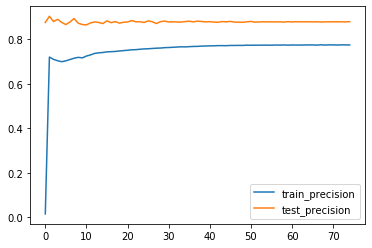

In [29]:
# Plot the precision metric at each itteration
plt.plot(result.history['precision'], label='train_precision');
plt.plot(result.history['val_precision'], label='test_precision');
plt.legend();

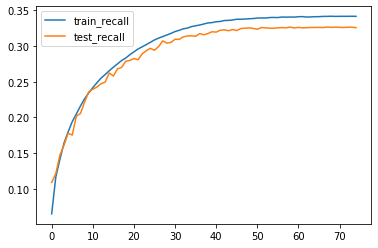

In [30]:
# Plot the recall metric at each itteration
plt.plot(result.history['recall'], label='train_recall');
plt.plot(result.history['val_recall'], label='test_recall');
plt.legend();